# Data Analysis 2 – Login Feature Clustering

This notebook loads the transaction and behaviour datasets, extracts the specified login‑related features, computes descriptive statistics, builds a clustering model (KMeans with PCA), and visualises the results.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14,8)


In [5]:
# Paths (adjust if needed)
TX_PATH = '../docs/транзакции в Мобильном интернет Банкинге.csv'
BEH_PATH = '../docs/поведенческие паттерны клиентов.csv'

def load_csv(path):
    for enc in ('cp1251','utf-8','latin1'):
        for sep in (';','	',','):
            try:
                df = pd.read_csv(path, encoding=enc, sep=sep, engine='python', header=1)
                if df.shape[1] > 1:
                    return df
            except Exception:
                pass
    raise FileNotFoundError(f'Unable to read {path}')

tx = load_csv(TX_PATH)
beh = load_csv(BEH_PATH)

# Normalise column names
tx.columns = [str(c).strip() for c in tx.columns]
beh.columns = [str(c).strip() for c in beh.columns]

beh


,transdate,cst_dim_id,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,last_os_categorical,logins_last_7_days,logins_last_30_days,login_frequency_7d,login_frequency_30d,freq_change_7d_vs_mean,logins_7d_over_30d_ratio,avg_login_interval_30d,std_login_interval_30d,var_login_interval_30d,ewm_login_interval_7d,burstiness_login_interval,fano_factor_login_interval,zscore_avg_login_interval_7d
0,'2025-03-05 00:00:00.000',4.530244e+08,2,2,Vivo V2116,Android/13,6,20,0.857143,0.6666666666666666,0.2857142857142857,0.300000,131460.000000,213919.478309,45761543200,23007.164410,0.238750,348102.412901,-0.221074
1,'2025-05-19 00:00:00.000',4.986364e+08,1,1,Xiaomi_m2006c3mg,Android/10,2,22,0.285714,0.7333333333333333,-0.6103896103896104,0.090909,101520.000000,82733.726442,6844869490.909091,178980.000000,-0.101959,67423.852353,0.936257
2,'2025-08-04 00:00:00.000',2.934905e+09,1,1,"iPhone16,1",iOS/18.5,2,2,0.285714,0.06666666666666667,3.2857142857142856,1.000000,67800.000000,-1.000000,-1.0,67800.000000,-1.000000,-1.000000,-1.000000
3,'2025-03-05 00:00:00.000',4.561731e+08,1,2,Vivo V2058,Android/13,5,37,0.714286,1.2333333333333334,-0.42084942084942084,0.135135,61394.594595,76777.321398,5894757081.081081,9400.733945,0.111330,96014.268357,-0.508739
4,'2025-06-26 00:00:00.000',2.933725e+09,1,1,"iPhone12,1",iOS/17.6.1,37,119,5.285714,3.966666666666667,0.33253301320528206,0.310924,22751.500000,33089.101678,1094888649.8319328,18828.504487,0.185127,48123.800621,-0.231693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8582,'2025-03-04 00:00:00.000',4.529513e+08,1,1,"iPhone10,5",iOS/16.7.10,16,40,2.285714,1.3333333333333333,0.7142857142857143,0.400000,47551.000000,87805.264382,7709764453.220339,12899.501572,0.297395,162136.746929,-0.151050
8583,'2025-03-30 00:00:00.000',4.529102e+08,2,2,"iPhone14,2",iOS/18.1,7,38,1.000000,1.2666666666666666,-0.21052631578947364,0.184211,68701.621622,97972.572168,9598624897.297297,19188.443255,0.175618,139714.677336,0.209940
8584,'2025-03-30 00:00:00.000',4.549666e+08,1,1,Xiaomi 2201117SG,Android/13,8,26,1.142857,0.8666666666666667,0.31868131868131855,0.307692,85338.181818,129096.796955,16665982984.09091,1043.012171,0.204065,195293.391879,-0.133728
8585,'2025-03-04 00:00:00.000',4.509121e+08,2,2,Xiaomi M2006C3LG,Android/11,37,62,5.285714,2.066666666666667,1.5576036866359444,0.596774,40484.545455,62661.679989,3926486139.020979,116861.355300,0.215007,96987.284776,-0.403456


Detected target column: Количество разных версий ОС (os_ver) за последние 30 дней до transdate — сколько разных ОС/версий использовал клиент


In [15]:
# Identify customer id column (common heuristics)
def find_id(cols):
    candidates = ['cst_dim_id','cust','client','customer','id']
    for cand in candidates:
        for c in cols:
            if cand.lower() in str(c).lower():
                return c
    return cols[0]

cust_tx = find_id(tx.columns)
cust_beh = find_id(beh.columns)
tx['cust_id'] = tx[cust_tx].astype(str).str.strip()
beh['cust_id'] = beh[cust_beh].astype(str).str.strip()

# Find target label in behaviour data – look at first few rows
def find_target(cols):
    for cand in ['target','is_fraud','fraud','label']:
        for c in cols:
            if cand.lower() in str(c).lower():
                return c
    # fallback: try to read the first non‑empty row for a numeric column
    sample = beh.head(5)
    for c in sample.columns:
        if sample[c].astype(str).str.contains(r'^[01]$').any():
            return c
    return None

target_col = find_target(beh.columns)
print(f"Detected target column: {target_col}")

if target_col:
    # raw‑string regex to avoid SyntaxWarning
    beh['target'] = beh[target_col].astype(str).str.extract(r'(\d)')[0].fillna('0').astype(int)
else:
    beh['target'] = 0
    print('Warning: target column not found – all rows set to 0')

Detected target column: target


In [16]:
# Identify customer id column (common heuristics)
def find_id(cols):
    candidates = ['cst_dim_id','cust','client','customer','id']
    for cand in candidates:
        for c in cols:
            if cand.lower() in str(c).lower():
                return c
    return cols[0]

cust_tx = find_id(tx.columns)
cust_beh = find_id(beh.columns)
tx['cust_id'] = tx[cust_tx].astype(str).str.strip()
beh['cust_id'] = beh[cust_beh].astype(str).str.strip()

# Find target label in behaviour data – look at first few rows
def find_target(cols):
    for cand in ['target','is_fraud','fraud','label']:
        for c in cols:
            if cand.lower() in str(c).lower():
                return c
    # fallback: try to read the first non‑empty row for a numeric column
    sample = beh.head(5)
    for c in sample.columns:
        if sample[c].astype(str).str.contains(r'^[01]$').any():
            return c
    return None

target_col = find_target(beh.columns)
print(f"Detected target column: {target_col}")

if target_col:
    # raw‑string regex to avoid SyntaxWarning
    beh['target'] = beh[target_col].astype(str).str.extract(r'(\d)')[0].fillna('0').astype(int)
else:
    beh['target'] = 0
    print('Warning: target column not found – all rows set to 0')

Detected target column: target


In [20]:
# List of login‑related features required by the user
login_features = [
    'logins_last_7_days', 'logins_last_30_days',
    'login_frequency_7d', 'login_frequency_30d',
    'freq_change_7d_vs_mean', 'logins_7d_over_30d_ratio',
    'avg_login_interval_30d', 'std_login_interval_30d', 'var_login_interval_30d', 'ewm_login_interval_7d',
    'burstiness_login_interval', 'fano_factor_login_interval', 'zscore_avg_login_interval_7d'
]

# Keep only columns that actually exist (case‑insensitive match)
present_features = []
for f in login_features:
    matches = [c for c in beh.columns if f.lower() == str(c).lower()]
    if matches:
        present_features.append(matches[0])
    else:
        # fuzzy fallback – contains the token
        for c in beh.columns:
            if f.split('_')[0] in str(c).lower():
                present_features.append(c)
                break

print('Features found:', present_features)


Features found: ['logins_last_7_days', 'logins_last_30_days', 'login_frequency_7d', 'login_frequency_30d', 'freq_change_7d_vs_mean', 'logins_7d_over_30d_ratio', 'avg_login_interval_30d', 'std_login_interval_30d', 'var_login_interval_30d', 'ewm_login_interval_7d', 'burstiness_login_interval', 'fano_factor_login_interval', 'zscore_avg_login_interval_7d']


In [21]:
# Subset and coerce to numeric
beh_sub = beh[['cust_id'] + present_features].copy()
for col in present_features:
    beh_sub[col] = pd.to_numeric(beh_sub[col].astype(str).str.replace(',', '.'), errors='coerce')

# Merge with behaviour (target)
merged = beh_sub.merge(tx[['cust_id','target']], on='cust_id', how='left')
merged['target'] = merged['target'].fillna(0).astype(int)

print('Merged shape:', merged.shape)


Merged shape: (777898, 15)


In [22]:
# Descriptive statistics per class
stats = merged.groupby('target')[present_features].describe().transpose()
display(stats)

# Simple summary table (mean)
summary = merged.groupby('target')[present_features].mean().T
summary.columns = ['Fraud','Non‑Fraud']
display(summary)


target                                          0            1
logins_last_7_days           count  772929.000000  4969.000000
                             mean       13.805181    13.973234
                             std        12.910959    12.697422
                             min         0.000000     0.000000
                             25%         5.000000     5.000000
...                                           ...          ...
zscore_avg_login_interval_7d min        -1.686303    -1.158660
                             25%        -0.323794    -0.320995
                             50%        -0.175575    -0.172307
                             75%         0.040669     0.039266
                             max         4.890622     4.569600

[104 rows x 2 columns]

,Fraud,Non‑Fraud
logins_last_7_days,1.380518e+01,1.397323e+01
logins_last_30_days,5.378503e+01,5.405092e+01
login_frequency_7d,1.972169e+00,1.996176e+00
login_frequency_30d,1.660515e+00,1.665969e+00
freq_change_7d_vs_mean,1.644403e-01,1.850261e-01
logins_7d_over_30d_ratio,2.717679e-01,2.766918e-01
avg_login_interval_30d,7.473490e+04,7.773362e+04
std_login_interval_30d,1.073709e+05,1.110961e+05
var_login_interval_30d,2.150428e+10,2.355483e+10
ewm_login_interval_7d,4.910048e+04,4.852708e+04


In [23]:
# Clustering pipeline
X = merged[present_features].values
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)
# PCA for 2‑D visualisation
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
merged['pca1'] = X_pca[:,0]
merged['pca2'] = X_pca[:,1]
# KMeans (k=4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
merged['cluster'] = kmeans.fit_predict(X_scaled)

print('Clustering completed. Cluster counts:')
print(merged['cluster'].value_counts())


Clustering completed. Cluster counts:
cluster
0    342064
1    298782
3     81650
2     55402
Name: count, dtype: int64


c:\Users\lengway\Desktop\lengway\ForteHackaton\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


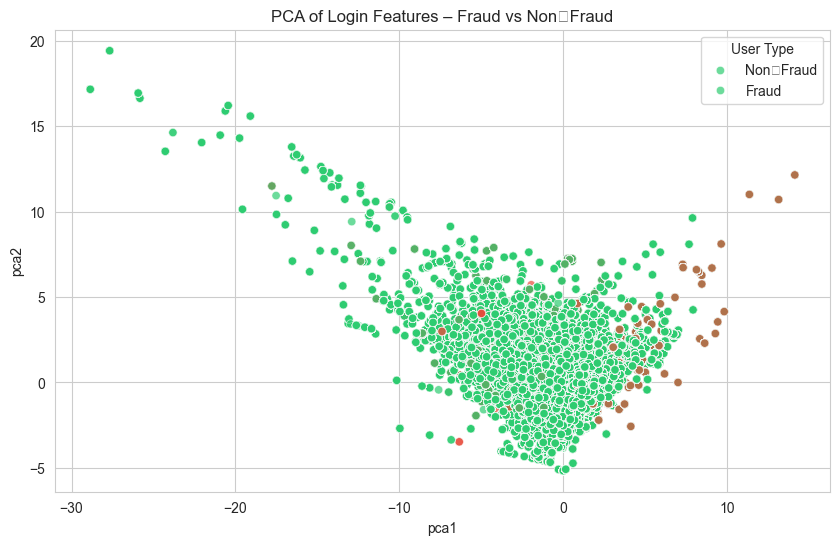

In [27]:
# Visualise PCA coloured by fraud label
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged, x='pca1', y='pca2', hue='target', palette=['#2ecc71','#e74c3c'], alpha=0.7)
plt.title('PCA of Login Features – Fraud vs Non‑Fraud')
plt.legend(title='User Type', labels=['Non‑Fraud','Fraud'], loc='upper right')
plt.show()


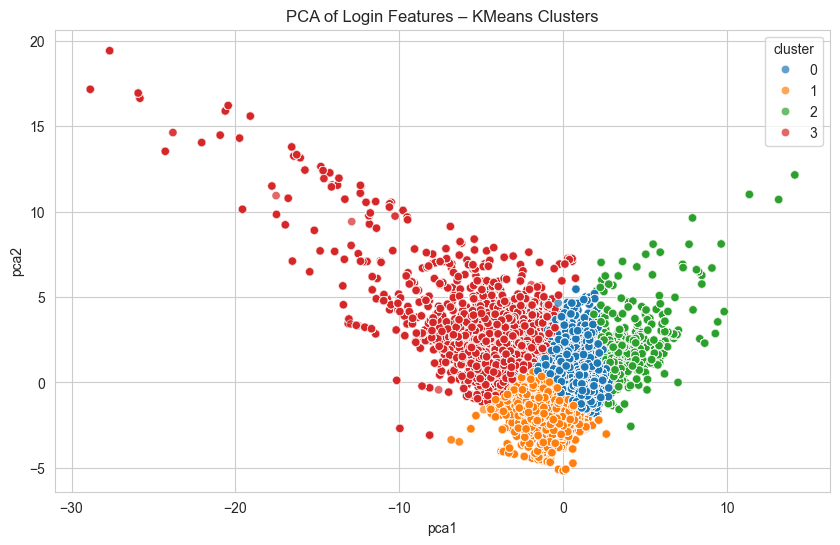

In [28]:
# Visualise PCA coloured by cluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged, x='pca1', y='pca2', hue='cluster', palette='tab10', alpha=0.7)
plt.title('PCA of Login Features – KMeans Clusters')
plt.show()


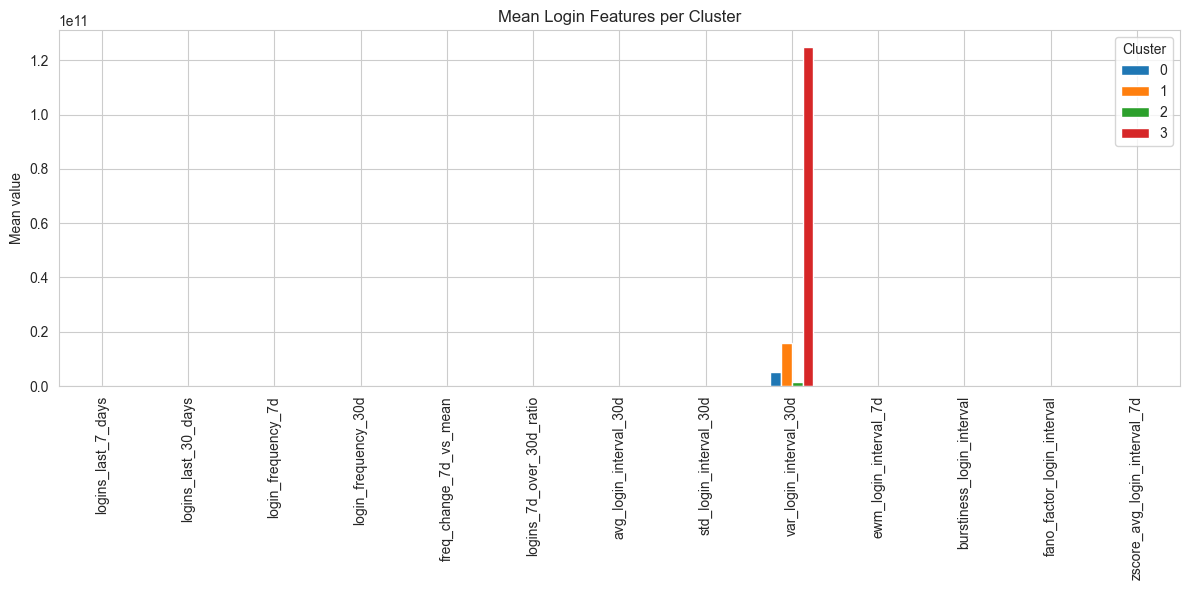

In [29]:
# Mean feature values per cluster (bar chart)
cluster_means = merged.groupby('cluster')[present_features].mean()
cluster_means.T.plot(kind='bar', figsize=(12,6))
plt.title('Mean Login Features per Cluster')
plt.ylabel('Mean value')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


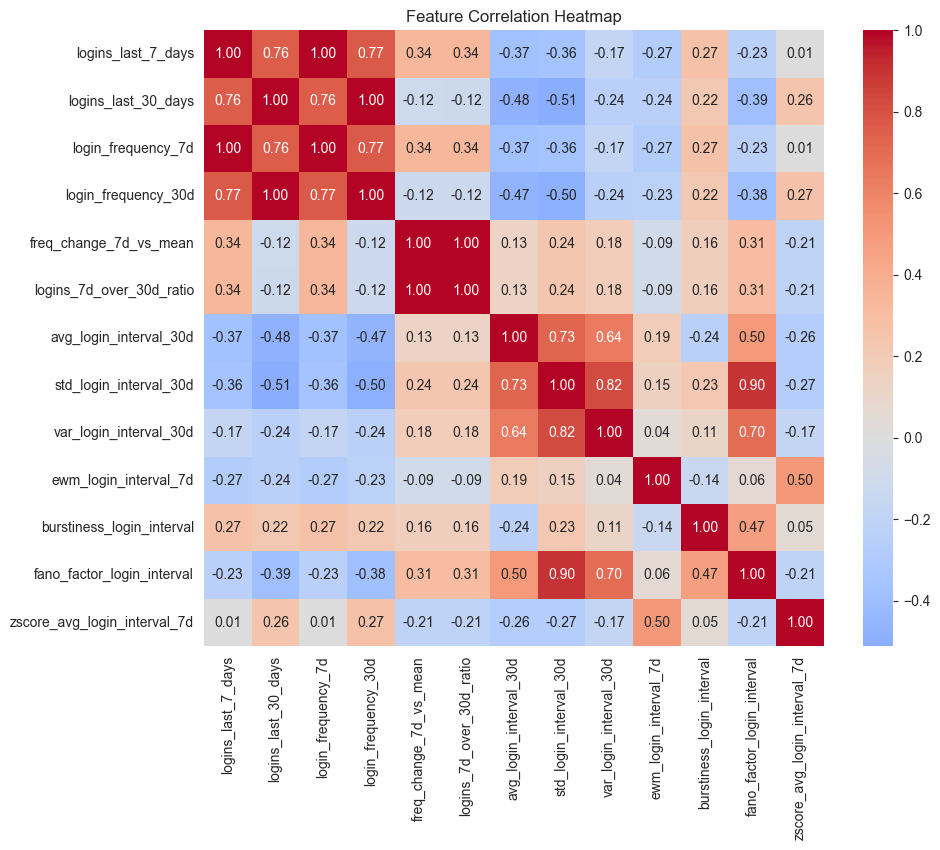

In [30]:
# Correlation heatmap of the login features
corr = merged[present_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()


In [31]:
# Save artefacts
merged.to_csv('login_features_merged.csv', index=False)
cluster_summary = merged.groupby('cluster')[present_features].mean()
cluster_summary.to_csv('cluster_summary_k4.csv')
print('Files saved: login_features_merged.csv, cluster_summary_k4.csv')


Files saved: login_features_merged.csv, cluster_summary_k4.csv
